In [1]:
import sys
sys.path.append('..')

import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, AutoModelForMaskedLM

from utils import *
from dataset import *
from preprocess import *
from wrapper import *
from models import *
from pipeline import PipelineGED

np.random.seed(1024)

device = torch.device("cpu")
# device = torch.device("cuda:0")
ntf()

In [2]:
MODEL_SIZE = 'base'
MODEL_ARCH = 'ernie'

In [3]:
np.random.seed(297)

train_df = pd.read_csv('../data/data-org/train.csv', sep='\t', index_col='id').iloc[np.random.choice(range(45000), size=50)]
test_df = pd.read_csv('../data/data-org/test.csv', sep='\t', index_col='id')

if MODEL_ARCH == 'ernie':
    model_name = 'nghuyong/ernie-gram-zh'
elif MODEL_ARCH == 'macbert':
    model_name = 'hfl/chinese-macbert-base' if MODEL_SIZE == 'base' else 'hfl/chinese-macbert-large'
else:
    print(f'Model {MODEL_ARCH} is not implemented yet.')
ner_model_name = 'uer/roberta-base-finetuned-cluener2020-chinese'


max_length = 64 if MODEL_SIZE == 'base' else 64

test_dataset_config = {
    'model_name':model_name,
    # 'aux_model_name':ner_model_name,
    'maxlength':max_length,
    'train_val_split':-1,
    'test':True, 
    'remove_username':False,
    'remove_punctuation':False, 
    'to_simplified':False, 
    'emoji_to_text':False, 
    'device':device,
    'split_words':True, 
    'cut_all':False, 
}

test = DatasetWithAuxiliaryEmbeddings(df=test_df.reset_index(), **test_dataset_config)
test.tokenize()
test.construct_dataset()

train_dataset_config = {
    'model_name':model_name,
    # 'aux_model_name':ner_model_name,
    'maxlength':max_length,
    'train_val_split':-1,
    'test':False, 
    'remove_username':False,
    'remove_punctuation':False, 
    'to_simplified':False, 
    'emoji_to_text':False, 
    'device':device,
    'split_words':True, 
    'cut_all':False, 
}

train = DatasetWithAuxiliaryEmbeddings(df=train_df.reset_index(), **train_dataset_config)
train.tokenize()
train.construct_dataset()

ntf()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\holaj\AppData\Local\Temp\jieba.cache
Loading model cost 0.861 seconds.
Prefix dict has been built successfully.
d:\Develop\chinese-grammar-error-detection\notebooks\..\dataset.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indexed_value = torch.tensor(value[index]).squeeze()
d:\Develop\chinese-grammar-error-detection\notebooks\..\dataset.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indexed_value = torch.tensor(value[index]).squeeze()


In [4]:
checkpoints = [
    # '../finetuned_models/ner_run_aug_74866/fold0/checkpoint-4065/pytorch_model.bin', 
    # '../finetuned_models/ner_run_aug_74866/fold1/checkpoint-12195/pytorch_model.bin', 
    # '../finetuned_models/ner_run_aug_74866/fold2/checkpoint-12195/pytorch_model.bin', 
    # '../finetuned_models/ner_run_aug_74866/fold3/checkpoint-8130/pytorch_model.bin', 
    # '../finetuned_models/ner_run_aug_74866/fold4/checkpoint-4065/pytorch_model.bin', 
    # '../finetuned_models/ner_run_aug_74866/fold5/checkpoint-8130/pytorch_model.bin', 
    # '../finetuned_models/ner_run_aug_74866/fold6/checkpoint-12195/pytorch_model.bin', 
    # '../finetuned_models/ner_run_aug_74866/fold7/checkpoint-8130/pytorch_model.bin', 
    '../finetuned_models/ner_run_aug_74866/fold8/checkpoint-4065/pytorch_model.bin', 
    # '../finetuned_models/ner_run_aug_74866/fold9/checkpoint-12195/pytorch_model.bin'
]
# checkpoints = [
#     '../finetuned_models/ner_run_aug_single/fold9/checkpoint-5014/pytorch_model.bin',
#     '../finetuned_models/ner_run_aug_single/fold9/checkpoint-7521/pytorch_model.bin',
# ]
if MODEL_ARCH == 'macbert':
    checkpoints = [f'../finetuned_models/balanced_trial/fold{i}/checkpoint-2865/pytorch_model.bin' for i in range(10)] 
elif MODEL_ARCH == 'ernie':
    checkpoints = ['../finetuned_models/balanced_trial_ernie_gram/fold0/checkpoint-1910/pytorch_model.bin'] 
else:
    print(f'Model {MODEL_ARCH} is not implemented yet.')

data_configs = {
    'model_name':model_name,
    'maxlength':max_length,
    'train_val_split':-1,
    'test':True, 
    'remove_username':False,
    'remove_punctuation':False, 
    'to_simplified':False, 
    'emoji_to_text':False, 
    'split_words':False, 
    'cut_all':False, 
}
clf = PipelineGED(
    model_name=model_name, 
    data_configs=data_configs, 
    single_layer_cls=True, 
    model_architecture='bert_with_clf_head', 
)

def apply_ged_pipeline(texts, majority_vote=False):
    if majority_vote:
        return clf(texts=texts, checkpoints=checkpoints, device=device, output_probabilities=True, display=False, majority_vote=True)
    probs, seq_probs, err_char_lst = clf(texts=texts, checkpoints=checkpoints, device=device, output_probabilities=True, display=False, majority_vote=False)
    return probs, seq_probs, err_char_lst

### Eval on train set

In [5]:
probs, seq_probs, err_char_lst = apply_ged_pipeline(train_df.text.values)
prediction = probs.argmax(1)

d:\Develop\chinese-grammar-error-detection\notebooks\..\dataset.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indexed_value = torch.tensor(value[index]).squeeze()


In [17]:
data = train_df[['label', 'text']]
data['prediction'] = prediction
data['score'] = probs[:, 1]
data['confidence'] = 1 - 2*np.abs(data.score.values - data.prediction)
data = data[['label', 'prediction', 'score', 'confidence', 'text']]
data['err_chars'] = err_char_lst
print(len(data[data.label != data.prediction]))

with pd.option_context('display.max_rows', None, 'display.max_columns', None, ):
    pd.options.display.max_colwidth = 100
    # display(data[data.label != data.prediction].sort_values(by='score'))
    display(data[data.label != data.prediction])
# data[data.label != data.prediction].to_csv('../case_analysis/aug.csv')
ntf()

5470


label  prediction     score  confidence  \
id                                               
7          0           1  0.798220    0.596440   
9          1           0  0.470234    0.059532   
14         0           1  0.874230    0.748460   
17         0           1  0.799638    0.599276   
18         0           1  0.923006    0.846013   
20         1           0  0.120427    0.759145   
21         0           1  0.939440    0.878880   
27         0           1  0.666900    0.333800   
106        0           1  0.929244    0.858489   
108        0           1  0.746920    0.493840   
112        0           1  0.949401    0.898802   
113        0           1  0.611402    0.222805   
127        1           0  0.105643    0.788713   
132        0           1  0.914277    0.828553   
134        0           1  0.973783    0.947566   
136        1           0  0.444296    0.111409   
143        1           0  0.345679    0.308641   
144        0           1  0.920816    0.841632   
145        0           1  0.975166    0.950333   
164        0           1  0.956872    0.913743   
166        1           0  0.490941    0.018119   
173        1           0  0.322845    0.354309   
184        0           1  0.847843    0.695685   
190        1           0  0.499363    0.001274   
217        1           0  0.441818    0.116364   
221        0           1  0.704451    0.408901   
230        1           0  0.487314    0.025371   
235        1           0  0.451394    0.097212   
239        0           1  0.923228    0.846456   
241        1           0  0.493583    0.012835   
243        1           0  0.071769    0.856463   
251        1           0  0.226102    0.547796   
256        1           0  0.415831    0.168338   
260        0           1  0.951039    0.902078   
264        0           1  0.781780    0.563560   
265        0           1  0.972290    0.944580   
277        0           1  0.601430    0.202860   
280        1           0  0.459724    0.080551   
282        0           1  0.968341    0.936682   
299        1           0  0.342803    0.314393   
305        0           1  0.597792    0.195584   
316        0           1  0.772898    0.545797   
321        0           1  0.902382    0.804764   
332        1           0  0.142289    0.715421   
335        0           1  0.944446    0.888891   
337        0           1  0.731442    0.462885   
358        1           0  0.265994    0.468013   
363        0           1  0.843009    0.686018   
375        0           1  0.698402    0.396803   
378        1           0  0.406675    0.186650   
413        0           1  0.688053    0.376107   
427        0           1  0.684925    0.369850   
446        0           1  0.962722    0.925444   
456        1           0  0.161973    0.676053   
457        0           1  0.705929    0.411858   
473        0           1  0.694972    0.389945   
493        0           1  0.766443    0.532887   
495        1           0  0.138530    0.722940   
497        0           1  0.971817    0.943634   
499        1           0  0.371189    0.257622   
509        1           0  0.363867    0.272267   
514        1           0  0.252603    0.494793   
522        1           0  0.265246    0.469507   
526        0           1  0.964052    0.928104   
534        0           1  0.652727    0.305454   
538        1           0  0.459637    0.080725   
539        0           1  0.917231    0.834461   
558        1           0  0.286092    0.427816   
559        0           1  0.823354    0.646708   
561        0           1  0.560405    0.120810   
564        0           1  0.993359    0.986718   
572        1           0  0.369342    0.261315   
599        1           0  0.314363    0.371273   
604        0           1  0.745804    0.491608   
606        0           1  0.766673    0.533347   
609        0           1  0.898984    0.797968   
610        1           0  0.347966    0.304069   
614        0           1  0.967001    0.934002   
616    

In [23]:
data[data.label != data.prediction].to_csv('../case_analysis/ensemble_pred_error.csv', encoding='utf-8')
data.to_csv('../case_analysis/ensemble_pred.csv', encoding='utf-8')

In [10]:
data = pd.read_csv('../case_analysis/ensemble_pred.csv')

# difficult_examples_idx = 1 + np.argwhere(
#     (seq_probs[:, 0, 0] > 0.5) *    # [CLS] is negative
#     (probs[:, 0] < 0.5)   # other tokens are positive
# ).flatten()
difficult_correct_examples_idx = (data.prediction == data.label) * (data.err_chars.map(lambda l: '[CLS]' not in l))
data[difficult_correct_examples_idx].to_csv('../case_analysis/ensemble_difficult_correct.csv')

In [34]:
data[difficult_examples_idx].to_csv('../case_analysis/ensemble_difficult.csv')

In [23]:
prediction, seq_predictions = apply_ged_pipeline(train_df.text.values, majority_vote=False)

data = train_df[['label', 'text']]
data['prediction'] = prediction
data = data[['label', 'prediction', 'text']]
print(len(data[data.label != data.prediction]))
with pd.option_context('display.max_rows', None, 'display.max_columns', None, ):
    pd.options.display.max_colwidth = 100
    # display(data[data.label != data.prediction].sort_values(by='score'))
    display(data[data.label != data.prediction])
# data[data.label != data.prediction].to_csv('../case_analysis/aug.csv')
ntf()

d:\Develop\chinese-grammar-error-detection\notebooks\..\dataset.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indexed_value = torch.tensor(value[index]).squeeze()


ValueError: too many values to unpack (expected 2)

In [ ]:
fp = ((data.label == 0).values * (data.prediction==1).values).sum()
fn = ((data.label == 1).values * (data.prediction==0).values).sum()
tp = ((data.label == 1).values * (data.prediction==1).values).sum()
tn = ((data.label == 0).values * (data.prediction==0).values).sum()

print(fp, fn, tp, tn)

precision = tp / (tp+fp)
recall = tp / (tp+fn)
f1 = 2*precision*recall / (precision+recall)
accuracy = (tp+tn) / (tp+tn+fp+fn)

print(precision, recall, f1, accuracy)

1208 5027 28733 10280
0.9596539861728065 0.8510959715639811 0.9021208458265961 0.8622038543140028


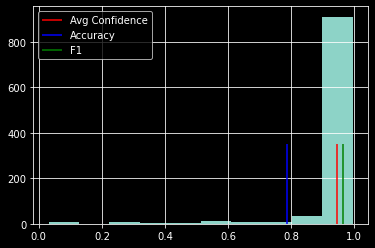

In [ ]:
import matplotlib.pyplot as plt
data.confidence.hist()
plt.vlines(x=data.confidence.mean(), ymin=0, ymax=350, colors='red', label='Avg Confidence')
plt.vlines(x=(tp+tn)/(tp+tn+fp+tn), ymin=0, ymax=350, colors='blue', label='Accuracy')
plt.vlines(x=f1, ymin=0, ymax=350, colors='green', label='F1')
plt.legend()

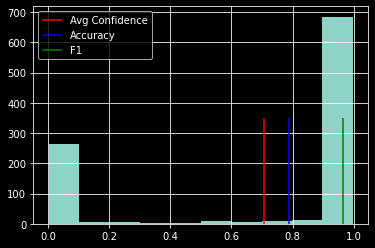

In [ ]:

data['score'].hist()
plt.vlines(x=data.score.mean(), ymin=0, ymax=350, colors='red', label='Avg Confidence')
plt.vlines(x=(tp+tn)/(tp+tn+fp+tn), ymin=0, ymax=350, colors='blue', label='Accuracy')
plt.vlines(x=f1, ymin=0, ymax=350, colors='green', label='F1')
plt.legend()

### Eval on Test Set

In [7]:
prediction = apply_ged_pipeline(test_df.text.values, majority_vote=True)
ntf()

d:\Develop\chinese-grammar-error-detection\notebooks\..\dataset.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indexed_value = torch.tensor(value[index]).squeeze()


In [6]:
data = test_df.copy(deep=True)
data['comp'] = pd.read_csv('../submissions/submission-v3-0.75624.csv', delimiter='\t').set_index('id').label

data['prediction'] = prediction[0]
# pred_df = pd.read_csv('../submissions-aug/submission.csv', delimiter='\t')
# pred_df['id'] = range(1, 1+len(pred_df))
# pred_df.set_index('id', inplace=True)
# data['prediction'] = pred_df.label

data = data[['comp', 'prediction', 'text']]
print(len(data[data.comp != data.prediction]))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(data[data.comp != data.prediction])

400


comp  prediction  \
id                       
1        0           1   
2        0           1   
3        0           1   
8        0           1   
10       0           1   
11       0           1   
12       0           1   
18       0           1   
22       0           1   
30       0           1   
34       0           1   
36       0           1   
40       0           1   
41       0           1   
42       0           1   
44       0           1   
46       0           1   
47       0           1   
52       0           1   
54       0           1   
55       0           1   
61       0           1   
63       0           1   
64       0           1   
67       0           1   
68       0           1   
69       0           1   
70       0           1   
71       0           1   
74       0           1   
75       0           1   
77       0           1   
82       0           1   
83       0           1   
85       0           1   
86       0           1   
87       0           1   
88       0           1   
90       0           1   
93       0           1   
96       0           1   
99       0           1   
103      0           1   
107      0           1   
112      0           1   
113      0           1   
114      0           1   
117      0           1   
119      0           1   
123      0           1   
124      0           1   
125      0           1   
128      0           1   
132      0           1   
135      0           1   
137      0           1   
138      0           1   
140      0           1   
142      0           1   
145      0           1   
148      0           1   
150      0           1   
152      0           1   
154      0           1   
155      0           1   
160      0           1   
164      0           1   
169      0           1   
173      0           1   
174      0           1   
175      0           1   
177      0           1   
178      0           1   
181      0           1   
182      0           1   
184      0           1   
186      0           1   
189      0           1   
197      0           1   
198      0           1   
199      0           1   
201      0           1   
206      0           1   
208      0           1   
210      0           1   
211      0           1   
213      0           1   
214      0           1   
223      0           1   
228      0           1   
230      0           1   
232      0           1   
234      0           1   
236      0           1   
240      0           1   
242      0           1   
243      0           1   
244      0           1   
247      0           1   
252      0           1   
255      0           1   
256      0           1   
257      0           1   
260      0           1   
262      0           1   
264      0           1   
265      0           1   
266      0           1   
269      0           1   
271      0           1   
272      0           1   
275      0           1   
276      0           1   
277      0           1   
279      0           1   
282      0           1   
284      0           1   
287      0           1   
292      0           1   
295      0           1   
297      0           1   
300      0           1   
302      0           1   
307      0           1   
309      0           1   
312      0           1   
314      0           1   
320      0           1   
324      0           1   
326      0           1   
328      0           1   
331      0           1   
335      0           1   
338      0           1   
339      0           1   
340      0           1   
342      0           1   
344      0           1   
351      0           1   
352      0           1   
355      0           1   
357      0           1   
360      0           1   
363      0           1   
364      0           1   
365      0           1   
369      0           1   
371      0           1   
372      0           1   
374      0           1   
375      0           1   
382      0           1   
38

In [7]:
test_probs, test_seq_probs, test_err_char_lst = apply_ged_pipeline(test_df.text.values)
ntf()

d:\Develop\chinese-grammar-error-detection\notebooks\..\dataset.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indexed_value = torch.tensor(value[index]).squeeze()


In [9]:
test_data = test_df.copy(deep=True)
test_data['comp'] = pd.read_csv('../submissions/submission-v3-0.75624.csv', delimiter='\t').set_index('id').label

test_data['prediction'] = test_probs.argmax(1)
test_data['score'] = test_probs[:, 1]
test_data['confidence'] = 1 - 2*np.abs(test_data.score.values - test_data.prediction)

test_data = test_data[['comp', 'prediction',  'score', 'confidence', 'text']]
test_data['error_chars'] = test_err_char_lst
print(len(test_data[test_data.comp != test_data.prediction]))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    # display(data[data.comp != data.prediction].sort_values(by='confidence'))
    display(test_data[test_data.comp != test_data.prediction])

151


comp  prediction     score  confidence  \
id                                             
13       1           0  0.152151    0.695698   
18       0           1  0.716468    0.432935   
24       1           0  0.276788    0.446424   
29       1           0  0.138510    0.722979   
39       1           0  0.499453    0.001094   
53       1           0  0.193182    0.613637   
57       1           0  0.495716    0.008568   
58       1           0  0.158018    0.683964   
72       1           0  0.407229    0.185542   
73       1           0  0.416135    0.167731   
76       1           0  0.364289    0.271423   
78       1           0  0.202266    0.595468   
79       1           0  0.425801    0.148398   
80       1           0  0.498024    0.003952   
82       0           1  0.803073    0.606146   
83       0           1  0.725832    0.451664   
91       1           0  0.473257    0.053486   
105      1           0  0.288071    0.423857   
115      1           0  0.252817    0.494366   
118      1           0  0.266080    0.467840   
121      1           0  0.375217    0.249566   
127      1           0  0.332613    0.334774   
163      1           0  0.103970    0.792060   
165      1           0  0.400580    0.198839   
168      1           0  0.424690    0.150620   
183      1           0  0.469833    0.060335   
191      1           0  0.255063    0.489874   
192      1           0  0.250266    0.499468   
193      1           0  0.042529    0.914942   
196      1           0  0.350740    0.298519   
197      0           1  0.783923    0.567845   
206      0           1  0.557218    0.114436   
221      1           0  0.381734    0.236531   
231      1           0  0.310870    0.378260   
233      1           0  0.426581    0.146839   
234      0           1  0.886737    0.773473   
237      1           0  0.479174    0.041653   
242      0           1  0.664223    0.328446   
248      1           0  0.222630    0.554740   
251      1           0  0.300505    0.398990   
258      1           0  0.236922    0.526156   
267      1           0  0.334786    0.330429   
274      1           0  0.325998    0.348005   
278      1           0  0.455357    0.089285   
283      1           0  0.432652    0.134696   
296      1           0  0.236891    0.526217   
301      1           0  0.441952    0.116095   
329      1           0  0.179502    0.640996   
344      0           1  0.669259    0.338517   
354      1           0  0.496348    0.007303   
365      0           1  0.529528    0.059055   
368      1           0  0.463243    0.073515   
373      1           0  0.478994    0.042013   
374      0           1  0.625152    0.250304   
375      0           1  0.568872    0.137744   
377      1           0  0.286124    0.427753   
379      1           0  0.336574    0.326851   
383      1           0  0.482152    0.035696   
384      0           1  0.612218    0.224436   
387      0           1  0.548241    0.096481   
395      1           0  0.273481    0.453038   
398      1           0  0.288621    0.422758   
404      0           1  0.615208    0.230416   
409      1           0  0.441152    0.117695   
412      1           0  0.282539    0.434923   
415      1           0  0.411808    0.176383   
425      1           0  0.272972    0.454057   
431      1           0  0.397519    0.204961   
440      0           1  0.547084    0.094167   
446      1           0  0.497529    0.004942   
449      0           1  0.612469    0.224938   
451      1           0  0.494245    0.011510   
461      1           0  0.329830    0.340340   
474      1           0  0.475442    0.049117   
480      1           0  0.384606    0.230789   
490      1           0  0.141493    0.717013   
494      0           1  0.545312    0.090623   
496      1           0  0.406755    0.186490   
501      1           0  0.169478    0.661045   
509      0           1  0.562145    0.124289   
512      0           1  0.686852    0.373704   
525      1           0

In [11]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pd.options.display.max_colwidth = 100
    display(test_data)

comp  prediction     score  confidence  \
id                                             
1        0           0  0.129373    0.741254   
2        0           0  0.231809    0.536381   
3        0           0  0.330965    0.338070   
4        1           1  0.927167    0.854335   
5        1           1  0.985842    0.971683   
6        1           1  0.973349    0.946698   
7        1           1  0.970840    0.941681   
8        0           0  0.367163    0.265675   
9        1           1  0.994114    0.988229   
10       0           0  0.259317    0.481365   
11       0           0  0.268861    0.462279   
12       0           0  0.011379    0.977243   
13       1           0  0.152151    0.695698   
14       1           1  0.958322    0.916644   
15       1           1  0.989363    0.978726   
16       1           1  0.991289    0.982579   
17       1           1  0.984249    0.968499   
18       0           1  0.716468    0.432935   
19       1           1  0.527201    0.054402   
20       1           1  0.945638    0.891276   
21       1           1  0.961667    0.923333   
22       0           0  0.443265    0.113471   
23       1           1  0.989900    0.979801   
24       1           0  0.276788    0.446424   
25       1           1  0.839078    0.678155   
26       1           1  0.830480    0.660961   
27       1           1  0.948783    0.897566   
28       1           1  0.871990    0.743980   
29       1           0  0.138510    0.722979   
30       0           0  0.016937    0.966125   
31       1           1  0.755630    0.511261   
32       1           1  0.933643    0.867287   
33       1           1  0.940831    0.881661   
34       0           0  0.026525    0.946949   
35       1           1  0.980932    0.961864   
36       0           0  0.434552    0.130896   
37       1           1  0.718837    0.437675   
38       1           1  0.948902    0.897803   
39       1           0  0.499453    0.001094   
40       0           0  0.055446    0.889109   
41       0           0  0.020092    0.959816   
42       0           0  0.484481    0.031037   
43       1           1  0.838841    0.677682   
44       0           0  0.103417    0.793165   
45       1           1  0.823858    0.647716   
46       0           0  0.359942    0.280115   
47       0           0  0.136083    0.727835   
48       1           1  0.774427    0.548853   
49       1           1  0.923480    0.846960   
50       1           1  0.915337    0.830674   
51       1           1  0.962109    0.924217   
52       0           0  0.056549    0.886903   
53       1           0  0.193182    0.613637   
54       0           0  0.078596    0.842807   
55       0           0  0.047574    0.904851   
56       1           1  0.906769    0.813537   
57       1           0  0.495716    0.008568   
58       1           0  0.158018    0.683964   
59       1           1  0.991399    0.982798   
60       1           1  0.971421    0.942841   
61       0           0  0.032695    0.934611   
62       1           1  0.742315    0.484630   
63       0           0  0.198178    0.603643   
64       0           0  0.066601    0.866797   
65       1           1  0.543115    0.086230   
66       1           1  0.992493    0.984986   
67       0           0  0.025204    0.949592   
68       0           0  0.162157    0.675686   
69       0           0  0.353635    0.292730   
70       0           0  0.116758    0.766485   
71       0           0  0.126650    0.746699   
72       1           0  0.407229    0.185542   
73       1           0  0.416135    0.167731   
74       0           0  0.038620    0.922760   
75       0           0  0.192801    0.614399   
76       1           0  0.364289    0.271423   
77       0           0  0.372060    0.255880   
78       1           0  0.202266    0.595468   
79       1           0  0.425801    0.148398   
80       1           0  0.498024    0.003952   
81       1           1  0.993615    0.987230   
82       0           1

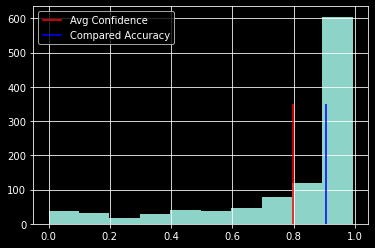

In [124]:
data.confidence.hist()
plt.vlines(x=data.confidence.mean(), ymin=0, ymax=350, colors='red', label='Avg Confidence')
plt.vlines(x=len(data[data.comp == data.prediction]) / len(data), ymin=0, ymax=350, colors='blue', label='Compared Accuracy')
# plt.vlines(x=f1, ymin=0, ymax=350, colors='green', label='F1')
plt.legend()

In [5]:
submissions = data[['prediction']].rename(columns={'prediction':'label'})
submissions['id'] = range(1, 1+len(submissions))
submissions = submissions[['id', 'label']]
submissions.to_csv('../submissions-aug/submission-da.csv', index=False, sep='\t')

# Loss

In [9]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch, focal_loss=True):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output['logits'], axis=-1)
        if focal_loss:
            loss = binary_focal_loss(output['logits'], batch["labels"].to(device), alpha=0.3, gamma=0.8, sum=False)
        else:
            loss = cross_entropy(output['logits'], batch["labels"].to(device), reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [5]:
# model = BertWithNER(bert_model=model_name, ner_model=ner_model_name)
model = AutoModelWithNER(model=model_name, ner_model=ner_model_name)
state_dict = torch.load(checkpoints[0], map_location=device)
# for key in list(state_dict.keys()):
#     state_dict[key.replace('bert', 'base_model')] = state_dict.pop(key)
model.load_state_dict(state_dict)
model.cuda()

Some weights of the model checkpoint at hfl/chinese-macbert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at uer/roberta-base-finetuned-cluener2020-chinese were not used when initializi

AutoModelWithNER(
  (base_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [10]:
train.dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'auxiliary_input_ids', 'labels'])
eval_outputs = train.dataset['val'].map(forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/283 [00:00<?, ?ba/s]

In [13]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display()

label                                               text
id                                                               
23495-1      1  海南“国际旅游岛”项目是我国由官方独立建造、独立规划、独立投资、独立管理、独立收支的特大型海...
39138        1                    央视“成语大会”栏目将国学娱乐化，有利于更多人研究和了解国学。
20777        1  随着反腐力度的进一步加大，新的反腐形势也在出现，有的甚至更加隐秘。反腐是一场持久的战争，它的...
30283        1  “汕优63”杂交稻近几年的年种植面积都超过1亿亩，平均亩产稳定在约500千克左右，不仅产量高...
34053        1  通过这几年的努力，使中国的水面舰艇研制水平和研制能力已经进入世界先进行列，这为中国海军执行远...
41533        1  在此次重庆市青少年科技创新大赛中，同学们常围在一起相互鼓劲并认真总结得失，赢得的远远不只是比...
15549        1         价格改革涉及利益复杂，不仅要坚持改革的方向，积极推进，而且要对方案认真周密研究部署。
42976        1      南通老百姓和海内外游客在狼山不仅可以感受到江海神韵，还可以感受到民族文化的永恒魅力之所在。
11432        1  据美国务院发言人维多利亚·纽兰9日在例行新闻发布会上表示，希望中国发挥影响力，采取措施帮助阻...
14855        1  2010年12月15日，海尔发布一款新型手机，这是一款待机功能十分突出的商务型手机，内置智能...
25522        0  出口退税增量实行中央和地方分担，是否会出现新的欠税和退税现象以及跨地区收购、出口贸易受限等问...
16300        1  我国在2010年里再次出台促进农业发展的一系列激励政策、调控政策和财政政策，极大地激发和调动...
14805        1        为解决“最后一公里”的问题，不少快递公司进行了自建门店、合作便利店、智能快递柜等方式。
39598        0  无论是提高艺术表现力，还是判断艺术的优劣高下和学术上的是非，都不靠行政命令，而要靠艰苦的艺术...
11108        0                         语文课程是一门学习语言文字运用的综合性、实践性课程。
25018        1  截至27日，利比亚反对派已经控制的黎波里绝大部分区域，但双方的战斗仍在南部市郊持续胶着。虽然...
35227        1  近日多个自媒体微信公众号发布了“缩短学制”的报道，该消息在家长群中被广泛转发传播，对此，省教...
13091        0              4月10日，铁路部门开始在全国实施新的列车运行方案，优化高铁列车开行路线。
38409        1            在新形势下，我们应该树立新的文化发展观，挖掘和推进文化体制创新和特色文化内涵。
12749        1  钱培芝提醒公众，不要轻信那些不负责任的宣传，也不要迷信巧舌如簧的推销诱惑，同时重视自我保护，...
40802        1  留学生们如果能为自己找准清晰的定位，为自己而留学，那么社会上“留学归国后找不到工作”的抱怨，...
24947        0                国务院要求加快推进宽带网络基础设施建设，进一步提速降费，提高服务水平。
28414        1   欧洲正面临十年来最严重的恐怖威胁，反恐任务十分艰巨，还需要进一步加快建立信息共享并加强情报分析。
29454        0                      为了防止此类事故再发生，本市相关部门采取了一系列安全措施。
24141        0  中东局势依然动荡，原油价格大幅上升，将对全球经济复苏产生不利影响，美国经济复苏的前景也因此蒙...
2680         1  很多同学都深切地说，自己体会到了鲁迅为了拯救国民灵魂而不惜呐喊、勇往直前的奋斗精神，以及他胸...
1066         0  学习绘画的人们都应该知道，孩子在先期学习的时候主要就是临摹，而几米的作品构图简单，线条和色彩...
12083        1  考古专家认为，山东兖州兴隆塔地宫的发掘，对古代佛教文化研究不仅有重大贡献，并且具有极高的历史...
16593        0                              通过这次活动，我们开阔了眼界，增长了知识。
3157         1           该书的出版把“名人”出书热又掀起一个高潮，同时也引来对名人出书热的更严厉的批评。
42884        0  桐城派的义法是应封建社会的政治需要而产生的，随着封建社会的逐步解体，打破桐城派义法的枷锁成为...
41437        1                      《朗读者》得到广泛好评，是因为其形式新颖、内涵丰富的缘故。
26084        1  由于存款准备金率上调，使得银行必须调整资产的配置，将资金从债券、贷款等高收益品种调整至准备金...
31929        0                               大气污染影响了农作物的播种、培育和收获。
15560        1  为进一步保障百姓餐桌安全，国家对施行已超过5年的《食品安全法》做了修订，因加大了惩处力度而被...
43020        1  有人认为在语文课堂上让学生读读武侠小说，能激发学生的阅读兴趣；也有人担心，将这些与法治精神背...
31417        1  央视请来教育部部长周济，请他就当前备受指责的高考阐述官方立场。周部长坦承民众所指出的当前高中...
41531        1  经济危机爆发之后，希腊政府面临的最大困境是如何解决失业问题，严峻的形势将巨大的挑战带给了希腊...
39273        1        天地境界又可以叫做哲学境界，因为如果通过哲学，获得对宇宙的某些了解，就能达到天地境界。
18414        0        对以中国为主的对美顺差大国而言，适当的妥协不可避免，但讨价还价和适度的斗争则是必须的。
21596        0  “才”固然重要，但如果没有一颗奉献于国家，为人民谋取福祉的心，你即使学富五车、满腹经纶，也不...
33742        0  我省出版界积极组织精品图书参展，介绍、展现本省出版界面对加入WTO的新形势，加快产业化发展的...
38394        1  11月1日，俄罗斯、伊朗和阿塞拜疆三国总统在德黑兰会面，商谈的内容之一就是加速沿里海的连通三...
6230         1        在央视的文化栏目《国家宝藏》中，通过明星守护人的讲述，使观众看到了国宝的“前世今生”。
24246        0  著名导演英达持美国绿卡，这意味着他在世界各地的收入都需要向美国国税局报税纳税，他不愿意这么做...
22848        1  华罗庚这个名字，对我国广大的学术界朋友以及青少年是非常熟悉的。他是世界第一流的数学家，他的成...
2785         0            文章在讲述每个小故事的前后常有些议论，这些议论是为了抒发作者对鲁迅的热爱之情。
43399        1             昨天有三个报社的记者来到了石家庄一中，对老师们和同学们进行了为期一天的采访。
28835        1              据报道，2019年我国新减降费超过2万亿元左右，与GDP比重超过2%左右。
17625        1                        我们要努力克服这种费力不讨好的学习方法，提高学习成绩。
18307        1  武汉邮电科学研究院近日完成超大容量光传输实验，其传输量是单模光纤最大传输量的5倍，可满足一根...
1127         1                 2010年我省大学招收的本科自费生，是自恢复高考制度以来最多的一年。
22890        0  各国政府都驱逐他，资产者都竞相诽谤他诅咒他。他对这一切毫不在意，把它们当作蛛丝一样轻轻拂去，...
1459         1  博士教育一旦以满足社会对“具有博士学位人才”的需要为目的，就必然会走向规模迅速扩大而质量急剧下滑。
32056        1   中国教育工作者对位于巴黎市中心塞纳河畔的“国立蓬皮杜文化艺术中心”的公共图书馆留下了深刻的印象。
28653        1        冬天的乌镇应该是旅游的淡季，但因为第二届互联网大会的召开，这座江南小镇变得热闹起来了。
20348        1  据审计署发布的最新数据显示，大多数领导干部能够执行中央决策部署，认真履行职责，但也有个别领导...
15086        1  中国共产党建党九十周年的庆祝活动，大大激发了全国人民炽烈的爱国热情和民族精神，为全面建设小康...
40994        1                    老头儿觉得嘴里有一股奇怪的味道